# Fine-Tuning Model for Watch vs non-Watch classification

In [1]:
import keras
from keras.applications import ResNet50
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.utils.data_utils import get_file

from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import flask
import io
import os
import math, re, os, io
from scipy import stats
import cv2
import quality_detection

/Users/gtobinobu/repo/clock_image/clock/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [100]:
base_model = ResNet50(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

In [102]:
new_layer = layers.Dense(1, activation='sigmoid', name='watch')
inp = base_model.input
out = new_layer(base_model.layers[-1].output)



In [103]:
new_model = models.Model(inp, out)

In [97]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [104]:
# freeze weights for all but the last two dense layers
for layer in new_model.layers[:-2]:
    layer.trainable = False



<keras.engine.topology.InputLayer object at 0x16ff04828> False
<keras.layers.convolutional.ZeroPadding2D object at 0x16ff04a90> False
<keras.layers.convolutional.Conv2D object at 0x16ff04198> False
<keras.layers.normalization.BatchNormalization object at 0x16ff04320> False
<keras.layers.core.Activation object at 0x16ff04c50> False
<keras.layers.pooling.MaxPooling2D object at 0x1716f3780> False
<keras.layers.convolutional.Conv2D object at 0x16ff11e80> False
<keras.layers.normalization.BatchNormalization object at 0x171705e80> False
<keras.layers.core.Activation object at 0x171736518> False
<keras.layers.convolutional.Conv2D object at 0x1717473c8> False
<keras.layers.normalization.BatchNormalization object at 0x17173e390> False
<keras.layers.core.Activation object at 0x171763588> False
<keras.layers.convolutional.Conv2D object at 0x17179d550> False
<keras.layers.convolutional.Conv2D object at 0x1717c16a0> False
<keras.layers.normalization.BatchNormalization object at 0x171793d30> False
<

In [95]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
# Change the batchsize according to your system RAM
train_batchsize = 100
 
train_generator = train_datagen.flow_from_directory(
        'labels/train',
        target_size=(224,224),
        batch_size=train_batchsize,
        class_mode='binary')

Found 292 images belonging to 2 classes.


In [105]:
# Compile the model
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = new_model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=10,
      verbose=1)
 
# Save the model
new_model.save('model_watch.h5')

Epoch 1/10
10/9 [================================] - 83s 8s/step - loss: 0.6900 - acc: 0.6491
Epoch 2/10
10/9 [================================] - 92s 9s/step - loss: 0.6846 - acc: 0.7405
Epoch 3/10
10/9 [================================] - 86s 9s/step - loss: 0.6820 - acc: 0.7553
Epoch 4/10
10/9 [================================] - 94s 9s/step - loss: 0.6766 - acc: 0.8266
Epoch 5/10
10/9 [================================] - 90s 9s/step - loss: 0.6762 - acc: 0.7869
Epoch 6/10
10/9 [================================] - 96s 10s/step - loss: 0.6722 - acc: 0.8424
Epoch 7/10
10/9 [================================] - 94s 9s/step - loss: 0.6725 - acc: 0.8278
Epoch 8/10
10/9 [================================] - 86s 9s/step - loss: 0.6689 - acc: 0.8708
Epoch 9/10
10/9 [================================] - 85s 8s/step - loss: 0.6683 - acc: 0.8414
Epoch 10/10
10/9 [================================] - 84s 8s/step - loss: 0.6665 - acc: 0.8771


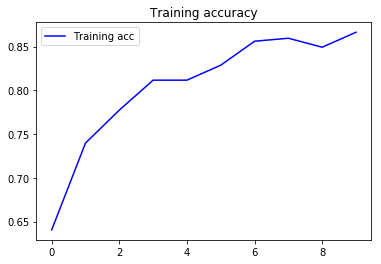

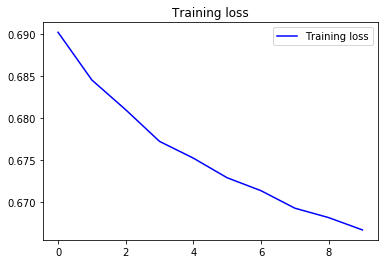

In [106]:
acc = history.history['acc']
loss = history.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
 
plt.show()

In [48]:
def image2resized_array(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    return image

def imagenet_format(image):
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)

    # return the processed image
    return image


In [166]:
test_result = []
dir_name = 'labels/test/watch'
for img in os.listdir(dir_name):
    image = Image.open(dir_name+'/'+img)
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    preds = model.predict(image)
    pred_label = model.predict_classes(image)
#     pred_label = 1 if preds>=0.5 else 0
    r = {"file": img, "correct_label": 1, "pred_label": pred_label, "probability": preds}
    test_result.append(r)
    
dir_name = 'labels/test/notwatch'
for img in os.listdir(dir_name):
    image = Image.open(dir_name+'/'+img)
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    preds = model.predict(image)
    pred_label = model.predict_classes(image)
    r = {"file": img, "correct_label": 0, "pred_label": pred_label, "probability": preds}
    test_result.append(r)

In [167]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
y_true = [x['correct_label'] for x in test_result]
y_pred = [x['pred_label'][0][0] for x in test_result]
y_score = [x['probability']*x['pred_label']+(1-x['probability'])*(1-x['pred_label'])  for x in test_result]
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('precision = ' + str(precision))
print('recall = ' + str(recall))
print('f1 score = ' + str(f1))

precision = 0.76
recall = 0.95
f1 score = 0.8444444444444444


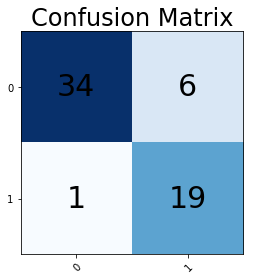

In [168]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cnf_matrix, cmap=plt.cm.Blues)

# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cnf_matrix[i, j],
                       ha="center", va="center", color="black", fontsize=30)

ax.set_title("Confusion Matrix", fontsize=24)
fig.tight_layout()
plt.show()